In [17]:
from dataclasses import dataclass
from datetime import datetime

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np 
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchfuzzy.fuzzy_layer import FuzzyLayer

In [18]:
batch_size = 256
learning_rate = 2e-3
weight_decay = 1e-2
num_epochs = 50
latent_dim = 12
fuzzy_dim = 3
beta = 1
gamma = 1 
fuzzy_labels = 12 #10 numbers and 2 classes on round closed loops in outlnes
unknown_classes_ratio = 0.0 # unknow samples rate
is_fuzzy_loss_active = True

prefix = "vae"
if is_fuzzy_loss_active:
    prefix = f"fuzzy_cvae_with_unknown_ratio_{unknown_classes_ratio}"
writer = SummaryWriter(f'runs/mnist/{prefix}_{datetime.now().strftime("%Y%m%d-%H%M%S")}')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if is_fuzzy_loss_active:
    gamma = 1
else:
    gamma = 0

In [19]:
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Lambda(lambda x: x.view(-1, 28, 28) - 0.5),
])

In [20]:
def get_target_and_mask(target_label, unknown_ratio):
    """
    Возвращает вектор целевого значения и маску в виде сдвоенного тензора

    Args:
        target_label (int): Метка класса
        unknown_ratio (float): Доля примеров в датасете, чья разметка будет игнорироваться при обучении
    
    Returns:
        tensor (2, 12)
    """
    t = F.one_hot(torch.LongTensor([target_label]), fuzzy_labels)
    if (target_label == 0) or (target_label == 6) or (target_label == 8) or (target_label == 9):
        t[0][fuzzy_labels - 2] = 1
    else:
        t[0][fuzzy_labels - 1] = 1
    m = torch.ones((1, fuzzy_labels)) if torch.rand(1) > unknown_ratio else torch.zeros((1, fuzzy_labels))
    
    return torch.cat((t, m), 0).to(device) 

In [21]:
# загружаем обучающую выборку
train_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=True, 
    transform = transform,
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x,unknown_classes_ratio))
)

In [22]:
# загружаем тестовую выборку
test_data = datasets.MNIST(
    '~/.pytorch/MNIST_data/', 
    download=True, 
    train=False, 
    transform=transform, 
    target_transform = transforms.Lambda(lambda x: get_target_and_mask(x, 0))
)
len(test_data)

10000

In [23]:
# Создаем итераторы датасетов
train_loader = torch.utils.data.DataLoader(
    train_data, 
    batch_size=batch_size, 
    shuffle=True,
    
)
test_loader = torch.utils.data.DataLoader(
    test_data, 
    batch_size=batch_size, 
    shuffle=False,
)

In [24]:
class Encoder(nn.Module):
    """
    Компонент энкодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Encoder, self).__init__()
                
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(8, 16, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(16, 32, kernel_size=5),
            nn.SiLU(),  
            nn.Conv2d(32, 64, kernel_size=5),
            nn.BatchNorm2d(64),
            nn.SiLU(),  
            nn.Flatten(),
            nn.Linear(9216, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(),  
            nn.Linear(625, 2 * latent_dim), # mean + variance.
        )
        self.softplus = nn.Softplus()
         
    def forward(self, x, eps: float = 1e-8):
        """
        Выход энкодера для чистого VAE.
        
        Args:
            x (torch.Tensor): Входной вектор.
            eps (float): Небольшая поправка к скейлу для лучшей сходимости и устойчивости.
        
        Returns:
            mu, logvar, z, dist
        """

        x = self.encoder(x)
        mu, logvar = torch.chunk(x, 2, dim=-1)
        scale = self.softplus(logvar) + eps
        scale_tril = torch.diag_embed(scale)
        dist = torch.distributions.MultivariateNormal(mu, scale_tril=scale_tril)
        z = dist.rsample()

        return mu, logvar, z

In [25]:
class Decoder(nn.Module):
    """
    Компонент декодера для VAE
    
    Args:
        latent_dim (int): Размер латентного вектора.
    """
    
    def __init__(self, latent_dim):
        super(Decoder, self).__init__()
                
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 625),
            nn.BatchNorm1d(625),
            nn.SiLU(), 
            nn.Linear(625, 9216),
            nn.BatchNorm1d(9216),
            nn.SiLU(), 
            nn.Unflatten(1,(64, 12, 12)),
            nn.ConvTranspose2d(64, 32, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(32, 16, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(16, 8, 5),
            nn.SiLU(), 
            nn.ConvTranspose2d(8, 1, 5),
            nn.Sigmoid() 
        )
         
    def forward(self, z):
        """
        Декодирует латентный вектор в исходное представление
        
        Args:
            z (torch.Tensor): Латентный вектор.
        
        Returns:
            x
        """

        x = self.decoder(z)
        
        return x

In [26]:
class CVAE(nn.Module):
    """
    Conditional Variational Autoencoder (C-VAE) 
    
    Args:
        latent_dim (int): Размер латентного вектора.
        labels_count (int): Количество выходов классификатора
    """
    def __init__(self, latent_dim, labels_count, fuzzy_dim):
        super(CVAE, self).__init__()

        self.encoder = Encoder(latent_dim)        
        self.decoder = Decoder(latent_dim)
        self.fuzzy_dim = fuzzy_dim
        self.fuzzy = nn.Sequential(
            FuzzyLayer.fromdimentions(fuzzy_dim, labels_count, trainable=True)
        )
        
        
    def forward(self, x):
        """
        Возвращает компоненты внутренних слоев CVAE, результаты реконструкции и классификации
        
        Args:
            x (torch.Tensor): Входной вектор.
        
        Returns:
            mu, x_recon, labels
        """

        mu, _,  _, = self.encoder(x)
        x_recon = self.decoder(mu)
        
        labels = self.fuzzy(mu[:,0:self.fuzzy_dim])

        return mu, x_recon, labels
    
    def half_pass(self, x):
        """
        Возвращает результаты работы энкодера и классификатора
        """
        mu, logvar, z = self.encoder(x)
        labels = self.fuzzy(mu[:,0:self.fuzzy_dim])

        return mu, logvar, z, labels
    
    def decoder_pass(self, x):
        return self.decoder(x)


In [27]:

#inp = torch.rand((3, 1, 28, 28))
#model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels)
#model.half_pass(inp)

In [28]:
def compute_loss(x, recon_x, mu, logvar, z, target_labels, predicted_labels):
    
    loss_recon = F.binary_cross_entropy(recon_x, x + 0.5, reduction='none').sum(-1).mean()
    
    tsquare = torch.square(mu)
    tlogvar = torch.exp(logvar)
    kl_loss = -0.5 * (1 + logvar - tsquare - tlogvar)
    loss_kl = kl_loss.sum(-1).mean()
            
    target_firings = target_labels[:,0,:]
    mask = target_labels[:,1,:]
    loss_fuzzy = (mask * torch.square(target_firings - predicted_labels)).sum(-1).mean()

    loss = loss_recon + beta * loss_kl + gamma * loss_fuzzy

    

    return loss, loss_recon, loss_kl, loss_fuzzy
    

In [29]:
model = CVAE(latent_dim=latent_dim, labels_count=fuzzy_labels, fuzzy_dim=2).to(device)

num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {num_params:,}')

model

Number of parameters: 11,709,099


CVAE(
  (encoder): Encoder(
    (encoder): Sequential(
      (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1))
      (1): SiLU()
      (2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
      (3): SiLU()
      (4): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
      (5): SiLU()
      (6): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): SiLU()
      (9): Flatten(start_dim=1, end_dim=-1)
      (10): Linear(in_features=9216, out_features=625, bias=True)
      (11): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (12): SiLU()
      (13): Linear(in_features=625, out_features=24, bias=True)
    )
    (softplus): Softplus(beta=1, threshold=20)
  )
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=12, out_features=625, bias=True)
      (1): BatchNorm1d(625, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [30]:
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

In [31]:
def train(model, dataloader, optimizer, prev_updates, writer=None):
    model.train()  
    
    for batch_idx, (data, target) in enumerate(tqdm(dataloader)):
        n_upd = prev_updates + batch_idx
        
        data = data.to(device)
        
        optimizer.zero_grad()  
        
        mu, logcar, z, labels = model.half_pass(data)  
        recon_x = model.decoder_pass(z)
        loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z, target, labels)
        
        loss.backward()
        
        if n_upd % 100 == 0:
            total_norm = 0.0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)
        
            print(f'Step {n_upd:,} (N samples: {n_upd*batch_size:,}), Loss: {loss.item():.4f} (Recon: {loss_recon.item():.4f}, KL: {loss_kl.item():.4f} Fuzzy: {loss_fuzzy.item():.4f}) Grad: {total_norm:.4f}')

            if writer is not None:
                global_step = n_upd
                writer.add_scalar('Loss/Train', loss.item(), global_step)
                writer.add_scalar('Loss/Train/BCE', loss_recon.item(), global_step)
                writer.add_scalar('Loss/Train/KLD', loss_kl.item(), global_step)
                writer.add_scalar('Fuzzy/Train/Loss', loss_fuzzy.item(), global_step)
                writer.add_scalar('GradNorm/Train', total_norm, global_step)
            
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)    
        
        optimizer.step()  
        
    return prev_updates + len(dataloader)

In [32]:
def test(model, dataloader, cur_step, writer=None):
    model.eval() 
    test_loss = 0
    test_recon_loss = 0
    test_kl_loss = 0
    test_fuzzy_loss = 0
    test_accuracy = 0
    
    with torch.no_grad():
        for data, target in tqdm(dataloader, desc='Testing'):
            data = data.to(device)
            mu, logcar, z, labels = model.half_pass(data)  
            recon_x = model.decoder_pass(z)
            loss, loss_recon, loss_kl, loss_fuzzy = compute_loss(data, recon_x, mu, logcar, z,  target, labels)
            
            test_loss += loss.item()
            test_recon_loss += loss_recon.item()
            test_kl_loss += loss_kl.item()
            test_fuzzy_loss += loss_fuzzy.item()
            pred_target = np.argmax(labels[:,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            target_labels =  np.argmax(target[:,0,0:(fuzzy_labels-2)].cpu().numpy(), axis=1)
            test_accuracy += np.sum(target_labels==pred_target) / len(pred_target)

    test_loss /= len(dataloader)
    test_recon_loss /= len(dataloader)
    test_kl_loss /= len(dataloader)
    test_fuzzy_loss /= len(dataloader)
    test_accuracy /= len(dataloader)

    print(f'====> Test set loss: {test_loss:.4f} (BCE: {test_recon_loss:.4f}, KLD: {test_kl_loss:.4f} Fuzzy: {test_fuzzy_loss:.4f} Accuracy {test_accuracy:.4f})')
    
    if writer is not None:
        writer.add_scalar('Loss/Test', test_loss, global_step=cur_step)
        writer.add_scalar('Loss/Test/BCE', loss_recon.item(), global_step=cur_step)
        writer.add_scalar('Loss/Test/KLD', loss_kl.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Loss', loss_fuzzy.item(), global_step=cur_step)
        writer.add_scalar('Fuzzy/Test/Accuracy', test_accuracy, global_step=cur_step)
        
        z = torch.randn(16, latent_dim).to(device)
        samples = model.decoder_pass(z)
        writer.add_images('Test/Samples', samples.view(-1, 1, 28, 28), global_step=cur_step)

In [33]:
prev_updates = 0
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    prev_updates = train(model, train_loader, optimizer, prev_updates, writer=writer)
    test(model, test_loader, prev_updates, writer=writer)

Epoch 1/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 0 (N samples: 0), Loss: 21.4038 (Recon: 18.1789, KL: 0.9947 Fuzzy: 2.2302) Grad: 18.4089
Step 100 (N samples: 25,600), Loss: 8.8598 (Recon: 6.9410, KL: 0.5688 Fuzzy: 1.3500) Grad: 16.0311
Step 200 (N samples: 51,200), Loss: 8.3836 (Recon: 6.5000, KL: 0.8588 Fuzzy: 1.0248) Grad: 11.5597


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 8.5437 (BCE: 6.3952, KLD: 1.1018 Fuzzy: 1.0467 Accuracy 0.5461)
Epoch 2/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 300 (N samples: 76,800), Loss: 7.9643 (Recon: 6.1613, KL: 0.9136 Fuzzy: 0.8895) Grad: 4.9057
Step 400 (N samples: 102,400), Loss: 7.7777 (Recon: 5.9683, KL: 1.0259 Fuzzy: 0.7835) Grad: 7.1065


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.9981 (BCE: 6.2115, KLD: 0.9644 Fuzzy: 0.8221 Accuracy 0.6684)
Epoch 3/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 500 (N samples: 128,000), Loss: 7.8661 (Recon: 5.9666, KL: 1.0827 Fuzzy: 0.8168) Grad: 5.0278
Step 600 (N samples: 153,600), Loss: 7.7771 (Recon: 5.9796, KL: 1.1250 Fuzzy: 0.6725) Grad: 11.6094
Step 700 (N samples: 179,200), Loss: 8.0423 (Recon: 6.2061, KL: 1.1266 Fuzzy: 0.7096) Grad: 5.0500


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.7870 (BCE: 5.8930, KLD: 1.2593 Fuzzy: 0.6346 Accuracy 0.7217)
Epoch 4/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 800 (N samples: 204,800), Loss: 7.7625 (Recon: 6.0222, KL: 1.1700 Fuzzy: 0.5703) Grad: 8.8861
Step 900 (N samples: 230,400), Loss: 7.4950 (Recon: 5.7997, KL: 1.1774 Fuzzy: 0.5179) Grad: 2.2320


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.5949 (BCE: 5.8661, KLD: 1.2567 Fuzzy: 0.4721 Accuracy 0.8422)
Epoch 5/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,000 (N samples: 256,000), Loss: 7.7536 (Recon: 6.0232, KL: 1.2509 Fuzzy: 0.4794) Grad: 3.7357
Step 1,100 (N samples: 281,600), Loss: 7.5615 (Recon: 5.9378, KL: 1.2241 Fuzzy: 0.3996) Grad: 3.0002


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.4300 (BCE: 5.8411, KLD: 1.1988 Fuzzy: 0.3901 Accuracy 0.9008)
Epoch 6/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,200 (N samples: 307,200), Loss: 7.4782 (Recon: 5.8471, KL: 1.2552 Fuzzy: 0.3759) Grad: 1.9185
Step 1,300 (N samples: 332,800), Loss: 7.4458 (Recon: 5.8290, KL: 1.2792 Fuzzy: 0.3376) Grad: 2.8194
Step 1,400 (N samples: 358,400), Loss: 7.3422 (Recon: 5.7815, KL: 1.2287 Fuzzy: 0.3319) Grad: 2.9263


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3308 (BCE: 5.7660, KLD: 1.2674 Fuzzy: 0.2974 Accuracy 0.9427)
Epoch 7/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,500 (N samples: 384,000), Loss: 7.2071 (Recon: 5.6350, KL: 1.2383 Fuzzy: 0.3338) Grad: 3.0256
Step 1,600 (N samples: 409,600), Loss: 7.1520 (Recon: 5.6307, KL: 1.2578 Fuzzy: 0.2636) Grad: 3.7576


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2986 (BCE: 5.7149, KLD: 1.3147 Fuzzy: 0.2690 Accuracy 0.9516)
Epoch 8/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,700 (N samples: 435,200), Loss: 7.3530 (Recon: 5.8104, KL: 1.2783 Fuzzy: 0.2643) Grad: 3.5562
Step 1,800 (N samples: 460,800), Loss: 7.1924 (Recon: 5.6404, KL: 1.2630 Fuzzy: 0.2891) Grad: 2.2525


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.3163 (BCE: 5.7935, KLD: 1.2349 Fuzzy: 0.2879 Accuracy 0.9444)
Epoch 9/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 1,900 (N samples: 486,400), Loss: 7.3093 (Recon: 5.6984, KL: 1.3175 Fuzzy: 0.2934) Grad: 2.5458
Step 2,000 (N samples: 512,000), Loss: 7.4092 (Recon: 5.8976, KL: 1.2427 Fuzzy: 0.2689) Grad: 3.0887
Step 2,100 (N samples: 537,600), Loss: 7.2393 (Recon: 5.6994, KL: 1.3055 Fuzzy: 0.2344) Grad: 1.9533


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2477 (BCE: 5.7284, KLD: 1.2746 Fuzzy: 0.2447 Accuracy 0.9581)
Epoch 10/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,200 (N samples: 563,200), Loss: 7.1558 (Recon: 5.6388, KL: 1.2647 Fuzzy: 0.2522) Grad: 2.5960
Step 2,300 (N samples: 588,800), Loss: 7.1750 (Recon: 5.6584, KL: 1.2871 Fuzzy: 0.2294) Grad: 2.4103


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2173 (BCE: 5.7090, KLD: 1.2826 Fuzzy: 0.2257 Accuracy 0.9576)
Epoch 11/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,400 (N samples: 614,400), Loss: 7.1431 (Recon: 5.6674, KL: 1.2773 Fuzzy: 0.1985) Grad: 2.5250
Step 2,500 (N samples: 640,000), Loss: 7.1299 (Recon: 5.6587, KL: 1.2429 Fuzzy: 0.2283) Grad: 2.8810


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.2313 (BCE: 5.7499, KLD: 1.2470 Fuzzy: 0.2343 Accuracy 0.9554)
Epoch 12/50


  0%|          | 0/235 [00:00<?, ?it/s]

Step 2,600 (N samples: 665,600), Loss: 7.2411 (Recon: 5.6745, KL: 1.2676 Fuzzy: 0.2990) Grad: 3.3437
Step 2,700 (N samples: 691,200), Loss: 7.1120 (Recon: 5.6318, KL: 1.2629 Fuzzy: 0.2173) Grad: 2.1385
Step 2,800 (N samples: 716,800), Loss: 7.1729 (Recon: 5.6878, KL: 1.2842 Fuzzy: 0.2009) Grad: 2.1010


Testing:   0%|          | 0/40 [00:00<?, ?it/s]

====> Test set loss: 7.1882 (BCE: 5.7298, KLD: 1.2593 Fuzzy: 0.1991 Accuracy 0.9625)
Epoch 13/50


  0%|          | 0/235 [00:00<?, ?it/s]

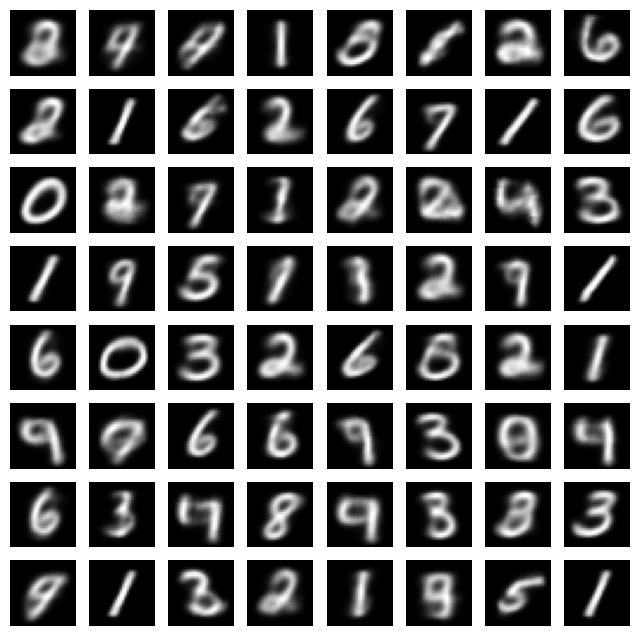

In [ ]:
z = torch.randn(64, latent_dim).to(device)
samples = model.decoder_pass(z)

# Plot the generated images
fig, ax = plt.subplots(8, 8, figsize=(8, 8))
for i in range(8):
    for j in range(8):
        ax[i, j].imshow(samples[i*8+j].view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[i, j].axis('off')

# plt.show()
plt.savefig('cvae_mnist.webp')

In [ ]:
# encode and plot the z values for the train set 
model.eval()
z_all = []
y_all = []
pred_y_all = []
pred_circ_all = []
with torch.no_grad():
    for data, target in tqdm(test_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, labels = model.forward(data)
        z_all.append(mu.cpu().numpy())
        y_all.append(np.argmax(target[:,0, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_y_all.append(np.argmax(labels[:, 0:(fuzzy_labels-2)].cpu().numpy(), axis=1))
        pred_circ_all.append(np.argmax(labels[:, (fuzzy_labels-2):].cpu().numpy(), axis=1))

Encoding:   0%|          | 0/40 [00:00<?, ?it/s]

In [ ]:
import pandas as pd

emnist_test = pd.read_csv("./data/EMNIST/emnist-letters.csv")
emnist_y = emnist_test["label"]
emnist_x = emnist_test.drop(labels = ["label"], axis = 1) 
del emnist_test 
#emnist_x = emnist_x / 255.0
emnist_x = emnist_x.values.reshape(-1, 28, 28)
emnist_x = transform(emnist_x)
emnist_loader = torch.utils.data.DataLoader(
    emnist_x, 
    batch_size=1, 
    shuffle=True,
)

len(emnist_x)

103600

Encoding:   0%|          | 0/103600 [00:00<?, ?it/s]

tensor([0.0000e+00, 2.7147e-39, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0125e-36,
        0.0000e+00, 0.0000e+00, 3.1662e-41, 0.0000e+00, 9.6167e-40, 5.9268e-35],
       device='cuda:0')


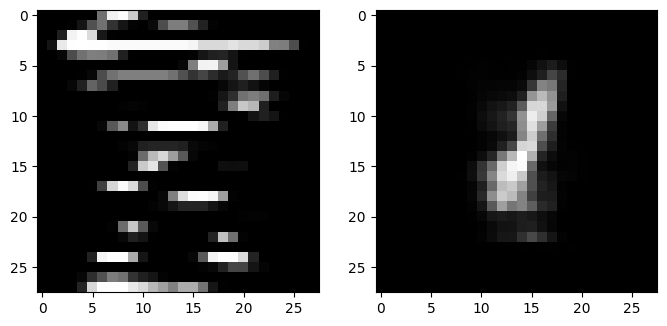

In [ ]:
model.eval()

with torch.no_grad():
    fig, ax = plt.subplots(1, 2, figsize=(8, 8))
    for data in tqdm(emnist_loader, desc='Encoding'):
        data = data.view((-1,1,28,28)).to(device)
        mu, x_recon, flabels= model.forward(data)
        print(flabels[0])
        ax[0].imshow(data.view(28, 28).cpu().detach().numpy(), cmap='gray')
        ax[1].imshow(x_recon.view(28, 28).cpu().detach().numpy(), cmap='gray')
        break


In [ ]:
import numpy as np
z_all = np.concatenate(z_all, axis=0)
y_all = np.concatenate(y_all, axis=0)
pred_y_all = np.concatenate(pred_y_all, axis=0)
pred_circ_all = np.concatenate(pred_circ_all, axis=0)

In [ ]:
np.sum(y_all==pred_y_all)/len(y_all)

0.984

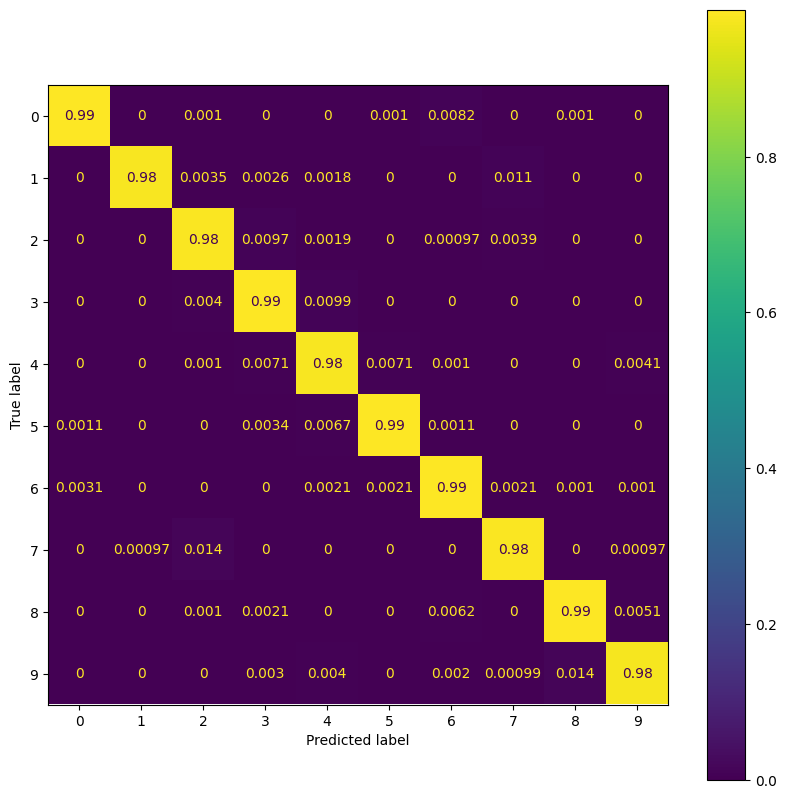

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_all, pred_y_all, normalize='true')
cmd = ConfusionMatrixDisplay(cm)
fig, ax = plt.subplots(figsize = (10, 10))
cmd.plot(ax=ax)

Text(0, 0.5, 'cvae 2')

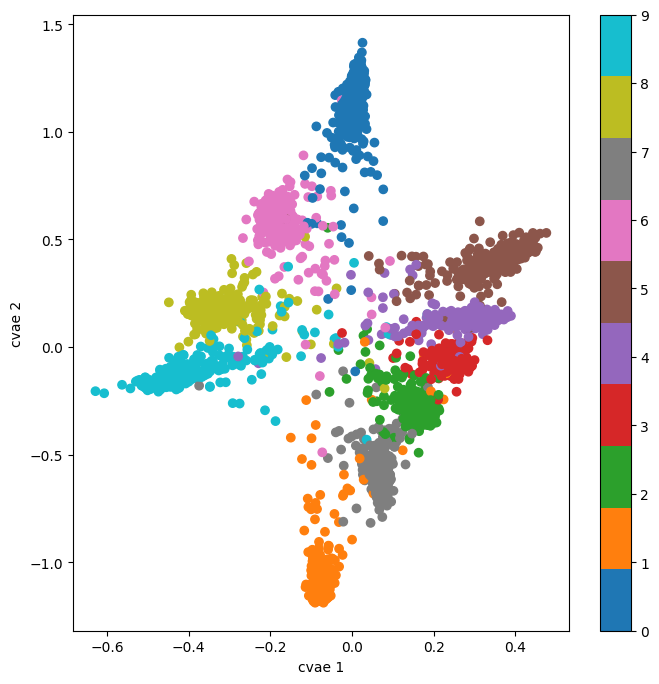

In [ ]:
plt.figure(figsize=(8, 8))
plt.scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10')
plt.colorbar()
plt.xlabel("cvae 1")
plt.ylabel("cvae 2")
# plt.show()
#plt.savefig('habr/mnist_2d_scatter_origin_labels_cvae.webp')

NameError: name 'z_all' is not defined

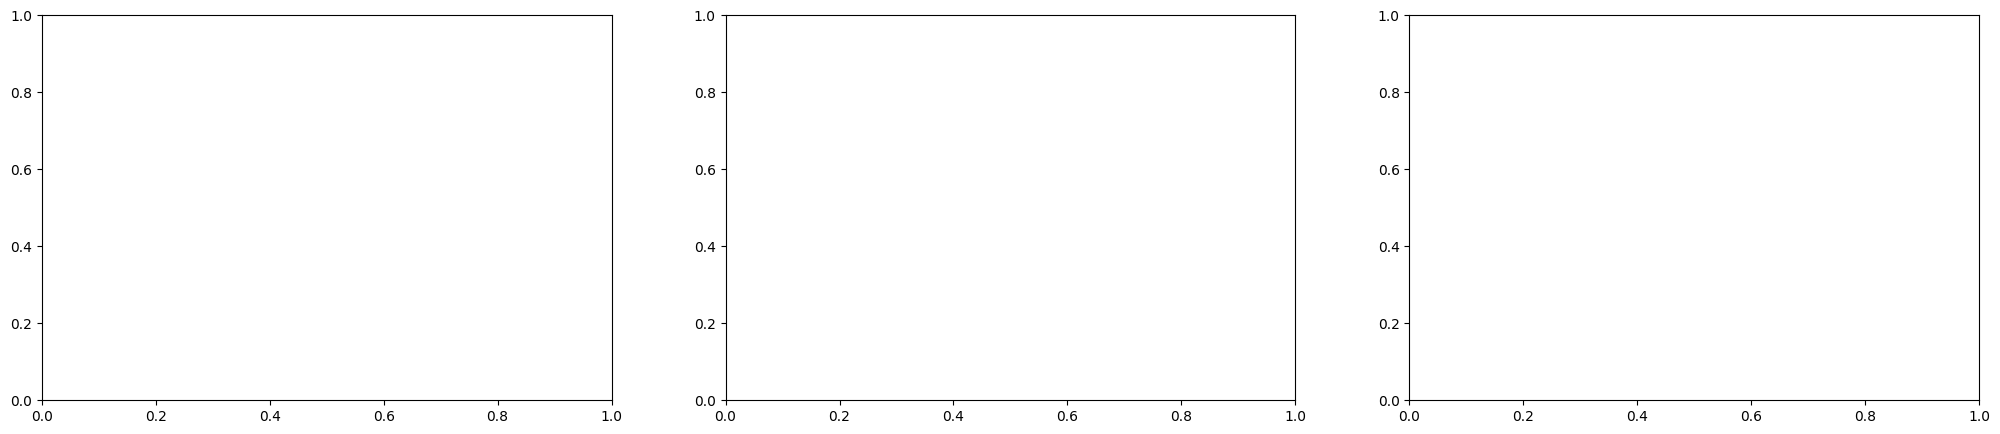

In [ ]:
figure, axis = plt.subplots(1, 3, figsize=(25, 5)) 
sc1 =axis[0].scatter(z_all[:, 0], z_all[:, 1], c=y_all, cmap='tab10', s=8)
axis[0].set_title("Original MNIST labels")
axis[0].set_xlabel("Fuzzy C-VAE component 1")
axis[0].set_ylabel("Fuzzy C-VAE component 2")

sc2 = axis[1].scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10', s=8)
axis[1].set_title("Predicted labels") 
axis[1].set_xlabel("Fuzzy C-VAE component 1")
axis[1].set_ylabel("Fuzzy C-VAE component 2")
sc3 = axis[2].scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='tab2')
axis[2].set_title("Predicted outline classes") 
axis[2].set_xlabel("Fuzzy C-VAE component 1")
axis[2].set_ylabel("Fuzzy C-VAE component 2")
figure.colorbar(sc1)
figure.colorbar(sc2)
figure.colorbar(sc3)
plt.show()
plt.savefig('papers/iiti24/fig2-b.eps', format="eps")

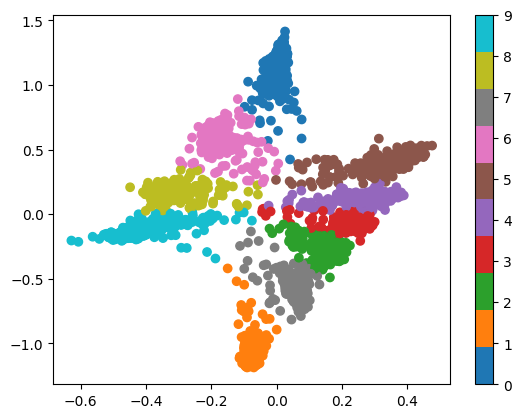

In [ ]:

plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_y_all, cmap='tab10')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_labels.webp')

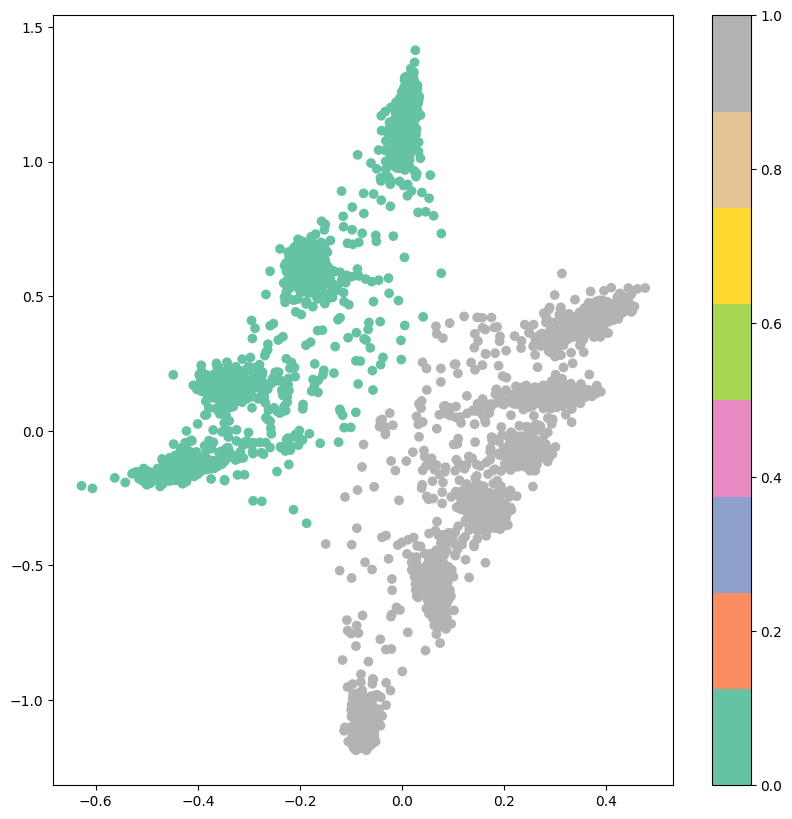

In [ ]:
plt.figure(figsize=(10, 10))
plt.scatter(z_all[:, 0], z_all[:, 1], c=pred_circ_all, cmap='Set2')
plt.colorbar()
# plt.show()
plt.savefig('mnist_2d_scatter_fuzzy_pred_circles.webp')

In [ ]:
n = latent_dim
z2 = torch.linspace(-1, -0.5, n)
z1 = torch.zeros_like(z2) + 1

z = torch.stack([z1, z2], dim=-1).to(device)
samples = model.decoder_pass(z)
samples = torch.sigmoid(samples)

# Plot the generated images
fig, ax = plt.subplots(1, n, figsize=(n, 1))
for i in range(n):
    ax[i].imshow(samples[i].view(28, 28).cpu().detach().numpy(), cmap='gray')
    ax[i].axis('off')
    
plt.savefig('cvae_mnist_interp.webp')

RuntimeError: mat1 dim 1 must match mat2 dim 0